In [1]:
from Network_PER import *
from DriveSim import *

pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


Use Prioritized Sampling: False
Episode 100 , average score(last 100 episodes): -2.15 wins: 20 eps: 0.9901
Episode 200 , average score(last 100 episodes): -2.9 wins: 34 eps: 0.9801
Episode 300 , average score(last 100 episodes): -2.75 wins: 49 eps: 0.9701
Episode 400 , average score(last 100 episodes): -2.15 wins: 68 eps: 0.9601
Episode 500 , average score(last 100 episodes): -2.9 wins: 82 eps: 0.9501
Episode 600 , average score(last 100 episodes): -3.2 wins: 94 eps: 0.9401
Episode 700 , average score(last 100 episodes): -2.0 wins: 114 eps: 0.9301
Episode 800 , average score(last 100 episodes): -2.0 wins: 134 eps: 0.9201
Episode 900 , average score(last 100 episodes): -2.15 wins: 153 eps: 0.9101
Episode 1000 , average score(last 100 episodes): -3.5 wins: 163 eps: 0.9001
Episode 1100 , average score(last 100 episodes): -3.2 wins: 175 eps: 0.8901
Episode 1200 , average score(last 100 episodes): -3.05 wins: 188 eps: 0.8801
Episode 1300 , average score(last 100 episodes): -3.05 wins: 201 e

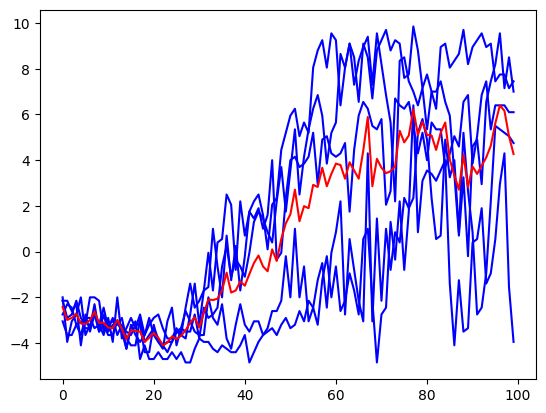

In [2]:
#시뮬레이션 학습 코드
EXP_COUNT = 5
n_runs = 10000
train_scores_1 = np.zeros([EXP_COUNT,n_runs//100])

#train_scores_1 = np.genfromtxt('20221003_concat_train_scores_1.csv', delimiter=',')

for exps in range(EXP_COUNT):
    wins = 0
    agent = Agent(lr=0.0005, gamma=0.99, n_actions=5, batch_size=64, epsilon=1.0, input_dims=[4, 6], per_on=False)
    sim = DriveSimulator()
    epsilons = []
    avg_score = 0.0

    agent.set_action_weights([5.0, 2.0, 8.0, 3.0, 3.0])
    
    for i in range(n_runs):
        over = False
        sim.reset(frame_rate=300)

        state = sim.get_sim_state()
        while not over:
            #print(agent.choose_action(state))
            action, pred = agent.choose_action(state)
            state_, stpRwd, sim_over = sim.step(action)
            over = sim_over

            agent.store_transition(state, action, stpRwd, state_, over, pred)
            state = state_

        agent.learn()
        agent.epsilon = 1.0 - (float(i)/float(n_runs))
        #scores.append(sim.agtRwd)
        
        avg_score += sim.agtRwd
        if sim.episode_count % 100 == 0:
            print('Episode', sim.episode_count, ', average score(last 100 episodes):', avg_score/100, 'wins:', sim.win_count, 'eps:', agent.epsilon)
            train_scores_1[exps, i//100] = (avg_score/100)
            epsilons.append(agent.epsilon)
            avg_score = 0.0

    agent.save_model('./models/q_20221018_concat_' + str(exps))
    plt.plot(train_scores_1[exps], 'b')
plt.plot(train_scores_1.mean(axis=0), 'r')
plt.savefig('test_20221018_concat.png')
print(train_scores_1)

In [ ]:
#이전에 저장한 학습 데이터 불러오기
train_scores_2 = np.genfromtxt('20221014_concat_train_scores.csv', delimiter=',')

for exps in range(EXP_COUNT):
    plt.plot(train_scores_1[exps], 'b')
plt.plot(train_scores_1.mean(axis=0), 'r')
plt.show()

for exps in range(EXP_COUNT):
    print(train_scores_2[exps])
    plt.plot(train_scores_2[exps], 'b')
plt.plot(train_scores_2.mean(axis=0), 'r')
plt.show()

plt.plot(train_scores_2.mean(axis=0), 'r')
plt.plot(train_scores_1.mean(axis=0), 'b')
plt.savefig('compare_20221004_per')

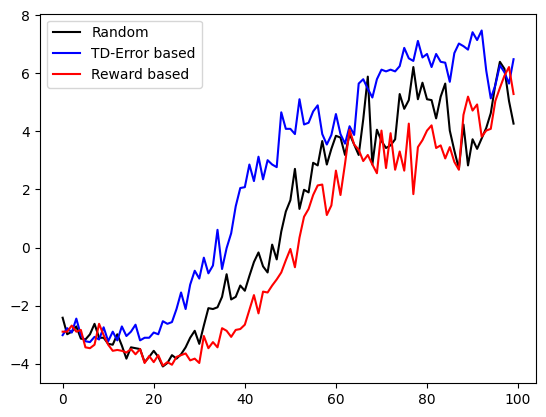

In [5]:
#학습 데이터 비교!!!!!
scores_Random = np.genfromtxt('20221017_concat_train_scores.csv', delimiter=',')
scores_Error_PER = np.genfromtxt('20221016_concat_train_scores.csv', delimiter=',')
scores_Reward_PER = np.genfromtxt('20221014_concat_train_scores.csv', delimiter=',')

plt.plot(scores_Random.mean(axis=0), 'k', label='Random')
plt.plot(scores_Error_PER.mean(axis=0), 'b', label='TD-Error based')
plt.plot(scores_Reward_PER.mean(axis=0), 'r', label='Reward based')
plt.legend()
plt.savefig("compare_sampling_methods_20221017.png")

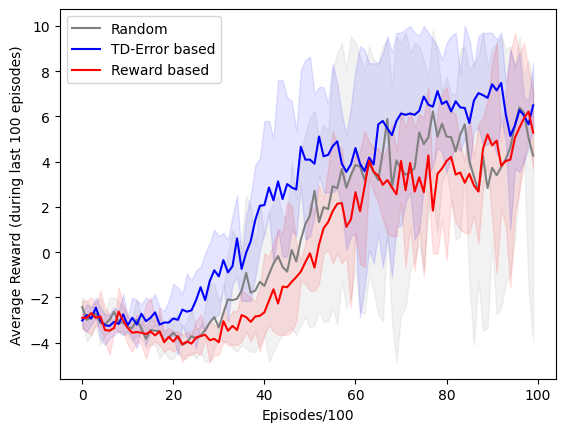

In [20]:
score_max = scores_Random.min(axis=0)
score_min = scores_Random.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'gray', alpha = 0.1)

score_max = scores_Error_PER.min(axis=0)
score_min = scores_Error_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'b', alpha = 0.1)

score_max = scores_Reward_PER.min(axis=0)
score_min = scores_Reward_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'r', alpha = 0.1)


plt.plot(scores_Random.mean(axis=0), 'gray', label='Random')
plt.plot(scores_Error_PER.mean(axis=0), 'b', label='TD-Error based')
plt.plot(scores_Reward_PER.mean(axis=0), 'r', label='Reward based')

plt.xlabel('Episodes/100')
plt.ylabel('Average Reward (during last 100 episodes)')
plt.legend()

plt.savefig("compare_sampling_methods_with_range_20221017.png")

In [ ]:
score_max = scores_Random.min(axis=0)
score_min = scores_Random.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'gray', alpha = 0.1)

score_max = scores_Reward_PER.min(axis=0)
score_min = scores_Reward_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'orange', alpha = 0.1)


plt.plot(scores_Random.mean(axis=0), 'gray', label='Random')
plt.plot(scores_Reward_PER.mean(axis=0), 'orange', label='Reward based')

plt.xlabel('Episodes/100')
plt.ylabel('Average Reward (during last 100 episodes)')
plt.legend()

plt.savefig("compare_aw_with_range_20221017.png")

In [3]:
np.savetxt('20221017_concat_train_scores.csv', train_scores_1, delimiter=",")